# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

In [1]:
import pandas as pd
import sys
sys.path.insert(0,'../')

In [2]:
# from data import plot_countries_all_plus_normalize_1 as plot
# from data import save_country_data_1 as save
# df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# # plot
# plot(df, ['US', 'Japan', 'Korea, South'])
# # save data
# save(df, ['US', 'Japan', 'Korea, South'])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import models
from models import model1, model2, model3

In [4]:
# prepare data
country = 'Korea, South'
df = pd.read_csv(country+'.csv',header=None)
data = np.array(df)

# split into calibration and validation sets
train_size = 50
data_c = data[:train_size,:]
data_v = data[train_size:,:]

# prepare noise
noise_arg = 1.

# prepare model 

# # model 1
# model = model1
# fixed_param = [data[0,1]]
# trans_param[0.01,0.0001]
# param_init = [0.5,0.5]  
# def prior(theta):
#     if theta[0]<0 or theta[1]<0 or theta[1]>1:   # r>0  0<=p<=1
#         return 1e-8
#     return 1

# model 3
model = model3
model_args = {}
model_args['Korea, South'] = [ [[data[0,1],100.,4], [1,.001], [19000,10.6]], \
                               [[data[0,1],100.,4], [1,.001], [10740,6.5]] ]
# model_args['US'] = [ [[data[0,1],100.,2], [100,1], [575000,20]], \
#                      [[data[0,1],100.,2], [100,1], [775000,12]] ]  # not well
model_args['US'] = [ [[data[0,1],100.,4], [100,.1], [25000,41.6]], \
                     [[data[0,1],100.,4], [1,.001], [646300,132.5]] ]
model_args['Japan'] = [ [[data[0,1],100.,4], [10,.01], [1000,8]], \
                        [[data[0,1],100.,4], [10,.01], [7300,135]] ]

def prior(theta):
    if theta[0]<0 or theta[1]<0:   # a>0,b>0
        return 0
    return 1

In [6]:
# prepare MCMC
def acceptance_rule(x, x_new):     # acceptance rule under log likelihood
    if x_new>x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))
    
def metropolis_hastings(log_likelihood,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    theta = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        theta_new = transition_model(theta)    
        lik = log_likelihood(theta,data)
        lik_new = log_likelihood(theta_new,data) 
        if (acceptance_rule(lik + np.log(prior(theta)),lik_new + np.log(prior(theta_new)))):            
            theta = theta_new
            accepted.append(theta_new)
        else:
            rejected.append(theta_new)            
    return np.array(accepted), np.array(rejected)


In [7]:
def solve_with_bayessian_mcmc(model, fix_params, trans_param, param_init,iterations,data):
    transition_model = lambda theta: np.random.normal(theta,trans_param,(2,))
    def log_likelihood(theta, data):
        tdata = data[:,0]
        ydata = data[:,1]
        return np.sum(-np.log(noise_arg * np.sqrt(2*np.pi) )-((ydata-model(theta,tdata,fix_params))**2) / (2*noise_arg**2))
    accepted, rejected = metropolis_hastings(log_likelihood,prior,transition_model,param_init,iterations,data,acceptance_rule)
    return accepted, rejected

In [8]:
def show_mcmc(accepted, rejected):
    fig = plt.figure(figsize=(10,12))

    ax = fig.add_subplot(2,1,1)
    ax.plot(accepted[:,0], accepted[:,1], label="Path")
    ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
    ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
    ax.set_xlabel("r")
    ax.set_ylabel("p")
    ax.legend()
    ax.set_title("MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

    to_show=50
    ax = fig.add_subplot(2,1,2)
    ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
    ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
    ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
    ax.set_xlabel("r")
    ax.set_ylabel("p")
    ax.legend()
    ax.set_title("MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.") 

In [9]:
def show_param_distribution(accepted, rejected, burn_in=0.5):
    show=int(-(1-burn_in)*accepted.shape[0])
    hist_show=int((1-burn_in)*accepted.shape[0])

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.plot(accepted[show:,0])
    ax.set_title("Trace for $a$")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("a")
    ax = fig.add_subplot(1,2,2)
    ax.hist(accepted[hist_show:,0], bins=20, density=True)
    ax.set_ylabel("Frequency (normed)")
    ax.set_xlabel("a")
    ax.set_title("Histogram of $a$")
    fig.tight_layout()

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.plot(accepted[show:,1])
    ax.set_title("Trace for $b$")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("b")
    ax = fig.add_subplot(1,2,2)
    ax.hist(accepted[hist_show:,1], bins=20, density=True)
    ax.set_ylabel("Frequency (normed)")
    ax.set_xlabel("b")
    ax.set_title("Histogram of $b$")
    fig.tight_layout()


## Calibration

(19579, 2)
[1.89766741e+04 1.06078459e+01]


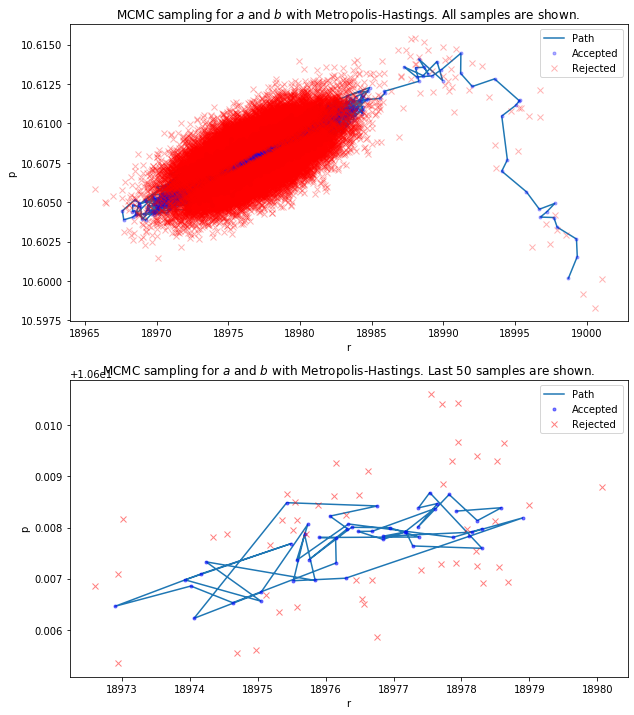

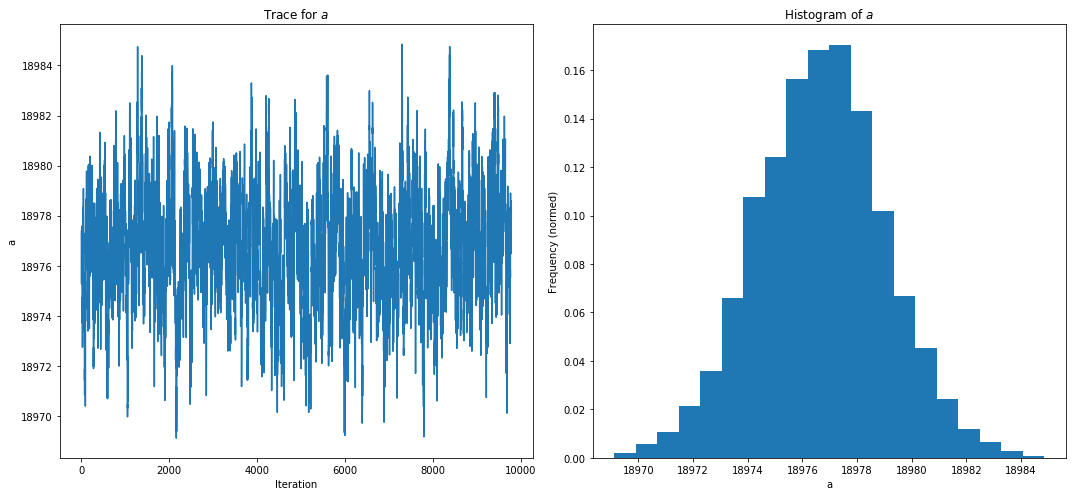

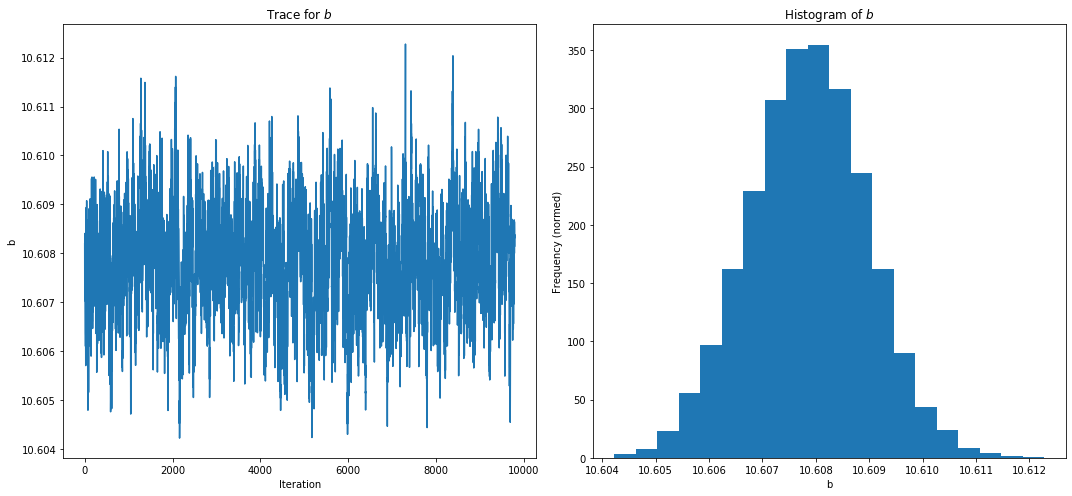

In [10]:
fix_params = model_args[country][0][0]  
trans_param = model_args[country][0][1]
param_init = model_args[country][0][2]

accepted, rejected = solve_with_bayessian_mcmc(model, fix_params, trans_param, param_init, iterations=50000, data=data_c)
print(accepted.shape)
show_mcmc(accepted, rejected)
show_param_distribution(accepted, rejected)

accepted_burned = accepted[-int((1-0.5)*len(accepted)):]
theta_opt = sum(accepted_burned)/len(accepted_burned)
print(theta_opt)

## Validation

(5451, 2)
[1.07375447e+04 6.49988114e+00]


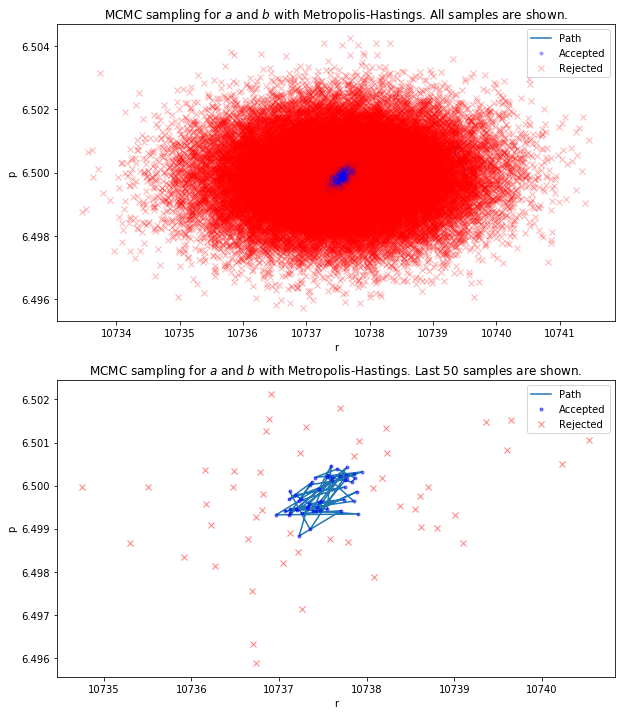

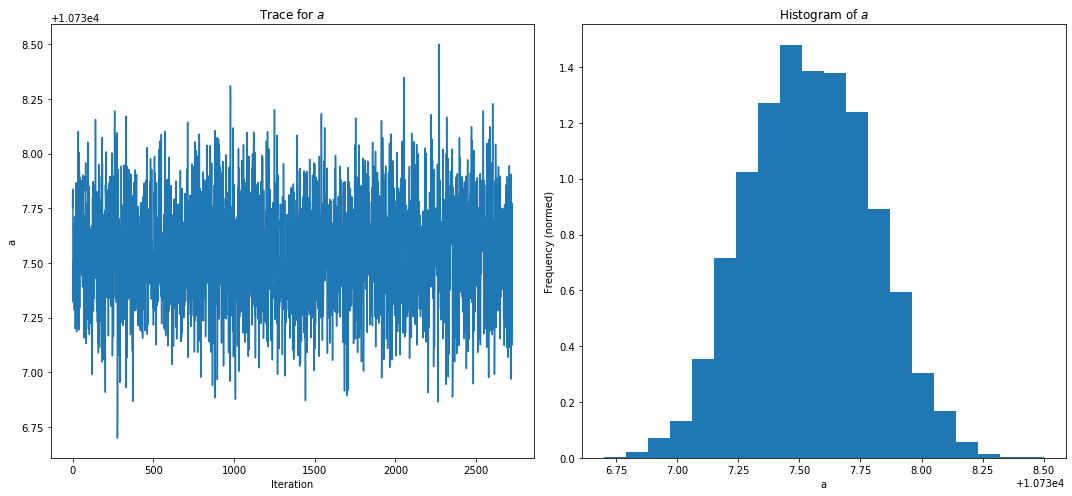

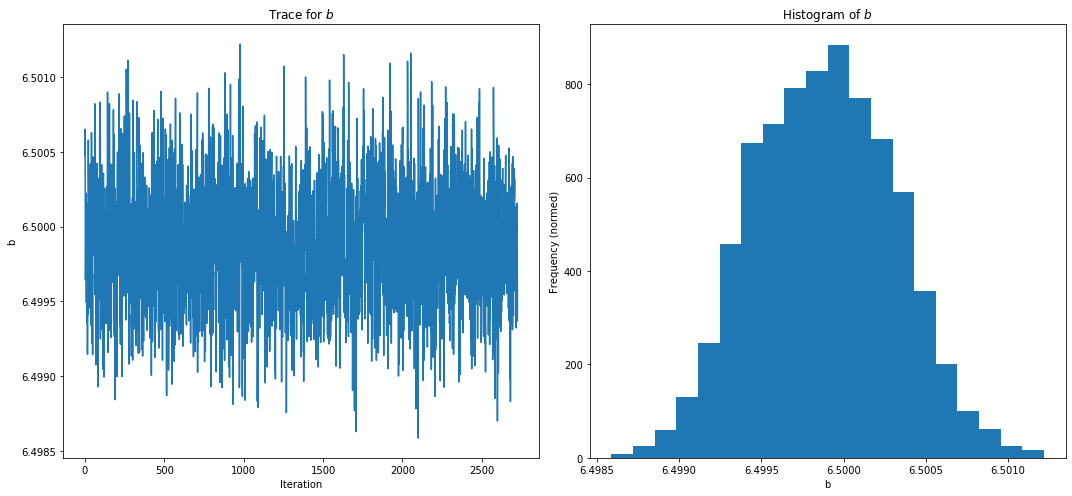

In [11]:
fix_params = model_args[country][1][0]  
trans_param = model_args[country][1][1]
param_init = model_args[country][1][2]

accepted, rejected = solve_with_bayessian_mcmc(model, fix_params, trans_param, param_init, iterations=50000, data=data)
print(accepted.shape)
show_mcmc(accepted, rejected)
show_param_distribution(accepted, rejected)

accepted_burned = accepted[-int((1-0.5)*len(accepted)):]
theta_opt = sum(accepted_burned)/len(accepted_burned)
print(theta_opt)

## Show fitting curves and QoI

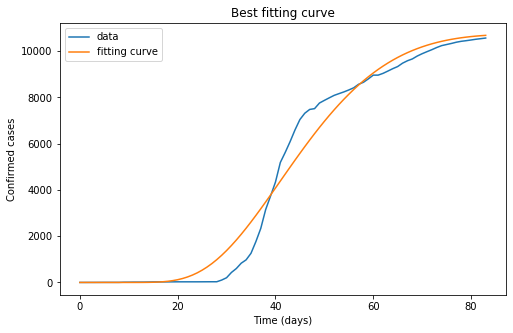

In [12]:
fig = plt.figure(figsize=(8,5))
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(data[:,0], model(theta_opt,data[:,0],fix_params), label='fitting curve')

plt.title('Best fitting curve')
plt.xlabel('Time (days)')
plt.ylabel('Confirmed cases')
plt.legend()

10738.544662491695


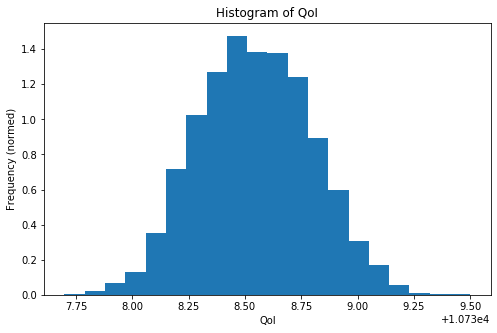

In [13]:
QoIs = [model(theta,[100],fix_params)[0] for theta in accepted_burned]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.hist(QoIs, bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("QoI")
ax.set_title("Histogram of QoI")

QoI = sum(QoIs)/len(QoIs)
print(QoI)

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.